In [1]:
# Essential imports 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score 
from sklearn.cluster import KMeans
import joblib
from sklearn.model_selection import GridSearchCV



%matplotlib inline 

In [2]:
# read data from 3 csv files
df_malicious= pd.read_csv("data/malicious_ips.csv")
df_watchers = pd.read_csv("data/watchers.csv")
df_autonomous_systems = pd.read_csv('data/autonomous_systems.csv')

####  Malicous IPS dataset : Data Preprocessing & Cleaning

In [3]:
df_autonomous_systems.shape

(15161, 3)

In [4]:
# Malicious Ips dataframe
df_malicious.head()

,id,unique_watcher_reported,attack_type,is_validated,as_num
0,3,{21},Exploit,NaN,16509.0
1,4,{25},Exploit,NaN,16509.0
2,"9,""{20354, 3587, 83714, 34181, 33423, 52497, 7...",NaN,NaN,NaN,NaN
3,78,{20},Bruteforce,True,9299.0
4,92,{28},Exploit,NaN,16509.0


In [5]:
# Rename Columns
df_malicious= df_malicious.rename(columns = { "unique_watcher_reported" :  "watcher_id" , "is_validated" : "malicious" , "as_num" : "AS_num"})

In [6]:
# Data Cleaning 
# Check for missing Values 

print(df_malicious.watcher_id.isna().sum())
print(df_malicious.attack_type.isna().sum())
print(df_malicious.AS_num.isna().sum())



# copy df_malicious to df_malicious_ips 
df_malicious_ips = df_malicious.copy()

# Drop the Column 'id' from df_malicious_ips
df_malicious_ips.drop( 'id' , inplace=True ,axis = 1)


5210
5210
5211


In [7]:
# create a list of elements of column id
id_list = df_malicious.id.to_list()

In [8]:
# find id cells that contain rows of data instead of just id
to_csv_list =  []
for value in id_list:
    if len(value)>7 :
        to_csv_list.append(value)

In [9]:
# transform ids list to pandas series
# create ids_list.csv from series

pd.Series(to_csv_list).to_csv('ids_list.csv',index=False)

In [10]:
# create new df containing id's list
new_df = pd.read_csv('ids_list.csv')

In [11]:
# name series as id to access it
new_df.columns=['id']

In [12]:
# split and expand values separated by " in id column to other pandas series
new_df = new_df.id.str.split('"', expand = True)


In [13]:
# split and expand values separated by comma
expanded = new_df[2].str.split(',',expand=True)

In [14]:
# concatenate new_df and expanded df
ips = pd.concat([new_df,expanded],axis=1)

In [15]:
# name columns of ips df
ips.columns = ['id','watcher_id','2','0','attack_type','malicious','AS_num']

In [16]:
# drop unnecessary empty columns from ips df
ips = ips.drop(['2','0'],axis=1)

In [17]:
# create a new df named malicious only contains original observations for which id is already intact
lista=[]

for i in range(len(df_malicious)):
    if len(df_malicious.id.values[i])>7:
        lista.append(i)


lista

df_malicious = df_malicious.drop(lista)



In [18]:
# clean id column from comma 

ips['id'] = ips['id'].replace(',','',regex=True)


In [19]:
# concatenate ips and df_malicious
df_malicious_ips = pd.concat([df_malicious,ips])

In [20]:
# final dataframe ready
df_malicious_ips

,id,watcher_id,attack_type,malicious,AS_num
0,3,{21},Exploit,NaN,16509.0
1,4,{25},Exploit,NaN,16509.0
3,78,{20},Bruteforce,True,9299.0
4,92,{28},Exploit,NaN,16509.0
5,93,{26},Exploit,NaN,16509.0
...,...,...,...,...,...
5205,1350838,"{96848, 7286}",Other,,14061.0
5206,1350840,"{100844, 7286, 84935}",Scanner,,139190.0
5207,1350844,"{7286, 47}",Other,,20473.0
5208,1351030,"{56291, 56324}",Spammer,,14061.0


In [21]:
# check for missing values in malicious column
df_malicious_ips.malicious.isna().sum()

21768

##### The column malicious contains 21768 missing values .
* WE could either drop the entire column and not include it in Modeling or Drop rows where : malicious is NaN 
    * Since it's not the target variable we will drop all rows from dataframe where malicious is Nan
* Train a Supervised classification Model with the rest of the rows .

In [22]:
# Drop rows where "all" column values are missing :
df_malicious_ips = df_malicious_ips.dropna(how = 'all')

In [23]:
df_malicious_ips.head()

,id,watcher_id,attack_type,malicious,AS_num
0,3,{21},Exploit,NaN,16509.0
1,4,{25},Exploit,NaN,16509.0
3,78,{20},Bruteforce,True,9299.0
4,92,{28},Exploit,NaN,16509.0
5,93,{26},Exploit,NaN,16509.0


In [24]:
# Delete all rows in dataframe where malicious is NaN but save copy in malicious
malicious =df_malicious_ips.copy()
# clean malicious column

df_malicious_ips['malicious'].replace('',np.nan,inplace=True)
df_malicious_ips.dropna(inplace=True)
df_malicious_ips.shape

(3195, 5)

In [25]:
# ReCheck for missing Values 
# Column : watcher_id
print(df_malicious_ips.watcher_id.isna().sum())
print(df_malicious_ips.attack_type.isna().sum())
print(df_malicious_ips.AS_num.isna().sum())

print('There are no missing values ')


0
0
0
There are no missing values 


In [26]:
# convert types to appropriate ones

# convert type of id to int  
df_malicious_ips['id'] = df_malicious_ips['id'].astype(int)


# convert AS_num to numeric float then int
df_malicious_ips['AS_num'] = df_malicious_ips['AS_num'].astype(float).astype(int)


In [27]:
# reset Index for entire df 
df_malicious_ips.reset_index(drop = True,inplace=True)


In [28]:
df_malicious_ips

,id,watcher_id,attack_type,malicious,AS_num
0,78,{20},Bruteforce,True,9299
1,508,{25},Exploit,True,174
2,617,{290},Spammer,True,202425
3,980,{77642},Scanner,True,208323
4,1146,{53},Bruteforce,True,3269
...,...,...,...,...,...
3190,1340791,"{58337, 30287, 49460, 66455, 86552, 72794, 518...",Bruteforce,True,14061
3191,1341647,"{76289, 96386, 66818, 60548, 62726, 101006, 66...",Other,True,396982
3192,1344817,"{95200, 94208, 93449, 94637, 61901, 47, 94769,...",Other,True,56046
3193,1348053,"{90512, 26228, 7286, 66455, 792, 3161, 77114, ...",Scanner,True,14061


In [29]:
# Feature Transorfmation :
# Encoding : 
# malicious column:



df_malicious_ips['malicious'] = df_malicious_ips['malicious'].replace("True",'1',regex=True)
df_malicious_ips['malicious'] = df_malicious_ips['malicious'].replace("False",'0',regex=True)
#df_malicious_ips['malicious'] = np.where(df_malicious_ips["malicious"]==False,0,1 )


In [30]:
# encode malicious to integer values
df_malicious_ips['malicious'] = df_malicious_ips['malicious'].astype(int)

In [31]:
df_malicious_ips

,id,watcher_id,attack_type,malicious,AS_num
0,78,{20},Bruteforce,1,9299
1,508,{25},Exploit,1,174
2,617,{290},Spammer,1,202425
3,980,{77642},Scanner,1,208323
4,1146,{53},Bruteforce,1,3269
...,...,...,...,...,...
3190,1340791,"{58337, 30287, 49460, 66455, 86552, 72794, 518...",Bruteforce,1,14061
3191,1341647,"{76289, 96386, 66818, 60548, 62726, 101006, 66...",Other,1,396982
3192,1344817,"{95200, 94208, 93449, 94637, 61901, 47, 94769,...",Other,1,56046
3193,1348053,"{90512, 26228, 7286, 66455, 792, 3161, 77114, ...",Scanner,1,14061


In [32]:
df_malicious_ips.malicious.value_counts()

malicious
1    2022
0    1173
Name: count, dtype: int64

In [33]:
# attack type 
attack_types = list(df_malicious_ips['attack_type'].unique())
print("Attack types are :",attack_types)
df_malicious_ips['attack_type'] = df_malicious_ips['attack_type'].replace(['Bruteforce','Exploit','Spammer','Scanner','Other','Crawler'],[0,1,2,3,4,5] )



Attack types are : ['Bruteforce', 'Exploit', 'Spammer', 'Scanner', 'Other', 'Crawler']


####  Watchers dataset : Data Preprocessing & Cleaning


In [34]:
df_malicious_ips['watcher_id']

0                                                    {20}
1                                                    {25}
2                                                   {290}
3                                                 {77642}
4                                                    {53}
                              ...                        
3190    {58337, 30287, 49460, 66455, 86552, 72794, 518...
3191    {76289, 96386, 66818, 60548, 62726, 101006, 66...
3192    {95200, 94208, 93449, 94637, 61901, 47, 94769,...
3193    {90512, 26228, 7286, 66455, 792, 3161, 77114, ...
3194                                           {7286, 47}
Name: watcher_id, Length: 3195, dtype: object

In [35]:
df_watchers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2121 entries, 0 to 2120
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                2121 non-null   int64  
 1   age_in_days       2121 non-null   int64  
 2   activity_in_days  2121 non-null   int64  
 3   hp_overlap_rate   2121 non-null   float64
 4   n_ips_reported    2121 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 83.0 KB


In [36]:
df_watchers.describe()

,id,age_in_days,activity_in_days,hp_overlap_rate,n_ips_reported
count,2121.000000,2121.000000,2121.000000,2121.000000,2121.000000
mean,62938.534182,94.243753,82.284771,0.221136,1010.522867
std,33898.638146,100.532101,88.950023,0.197697,5305.223103
min,15.000000,1.000000,1.000000,0.000000,0.000000
25%,37052.000000,25.000000,23.000000,0.070000,57.000000
50%,72793.000000,51.000000,44.000000,0.180000,238.000000
75%,94671.000000,126.000000,117.000000,0.330000,681.000000
max,102030.000000,407.000000,401.000000,1.000000,121623.000000


####  Autonomous Systems dataset : Data Preprocessing & Cleaning


In [37]:
df_autonomous_systems.head(10)

,as_num,n_ips_reported,as_name
0,3320,55294,Deutsche Telekom AG
1,4134,39891,Chinanet
2,16509,30914,AMAZON-02
3,3209,23288,Vodafone GmbH
4,14061,19829,DIGITALOCEAN-ASN
5,15895,18818,Kyivstar PJSC
6,4837,17182,CHINA UNICOM China169 Backbone
7,3462,13885,Data Communication Business Group
8,14618,10450,AMAZON-AES
9,6805,9536,Telefonica Germany


In [38]:
df_autonomous_systems.shape

(15161, 3)

In [39]:
# convert AS_num & watcher_id to numeric
df_autonomous_systems['n_ips_reported'] = df_autonomous_systems['n_ips_reported'].astype(int)
# convert as name to string type
df_autonomous_systems['as_name'] = df_autonomous_systems['as_name'].astype(str)

#### EDA Questions 

Number of IPs reported by type of attack

([<matplotlib.axis.XTick at 0x1faa3d19210>,
 [Text(0, 0, 'Bruteforce'),
  Text(1, 0, 'Exploit'),
  Text(2, 0, 'Spammer'),
  Text(3, 0, 'Scanner'),
  Text(4, 0, 'Other'),
  Text(5, 0, 'Crawler')])

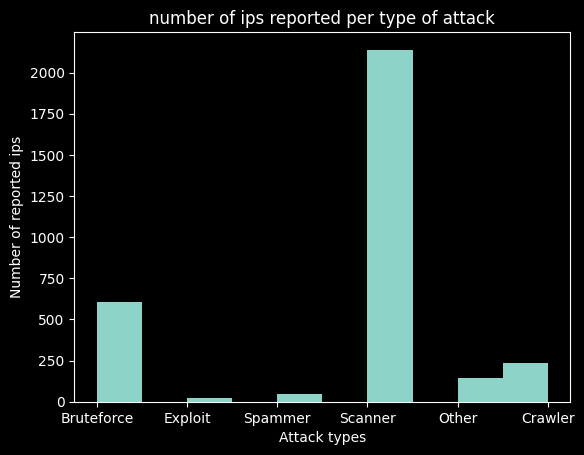

In [40]:
# Visualize Data
# attack types 
plt.hist(df_malicious_ips['attack_type'] )
plt.title("number of ips reported per type of attack")
plt.xlabel("Attack types")
plt.ylabel("Number of reported ips")
plt.xticks([0,1,2,3,4,5],attack_types)

Names of top 10 AS hostings in malicious ips number



In [41]:
# find AS numbers for which attacks are malicious
AS_num_malicious = df_malicious_ips.loc[df_malicious_ips['malicious'] == 1,'AS_num']

# create a dictionary for hwich keys are AS_num and values are Counts of AS_num
out = AS_num_malicious.value_counts().to_dict()
out
top_10_AS = sorted(out, key=out.get, reverse=True)[:10]


In [42]:
top_10_AS

[53667, 14061, 208294, 208843, 62744, 4134, 16276, 24940, 8075, 45090]

In [43]:
df_autonomous_systems

,as_num,n_ips_reported,as_name
0,3320,55294,Deutsche Telekom AG
1,4134,39891,Chinanet
2,16509,30914,AMAZON-02
3,3209,23288,Vodafone GmbH
4,14061,19829,DIGITALOCEAN-ASN
...,...,...,...
15156,399439,1,ATV-PUBLIC
15157,399521,1,BNS-AMERICA
15158,399567,1,HOMETIME-ASN1
15159,399686,1,SEMIBAND


In [44]:
# Get names from AS dataframe 

for e in top_10_AS:
   print(df_autonomous_systems.loc[df_autonomous_systems['as_num'] == e,'as_name'].values)

['PONYNET']
['DIGITALOCEAN-ASN']
['Cia Triad Security LLC']
['Alpha Strike Labs GmbH']
['QUINTEX']
['Chinanet']
['OVH SAS']
['Hetzner Online GmbH']
['MICROSOFT-CORP-MSN-AS-BLOCK']
['Shenzhen Tencent Computer Systems Company Limited']


Top 10 AS for ips that perform highest number of attacks

In [45]:
top_10_AS_dict = df_malicious_ips.AS_num.value_counts()[:10].to_dict()
print('AS number','number of attacks','\n',top_10_AS_dict)

AS number number of attacks 
 {13335: 922, 8075: 248, 53667: 247, 14061: 124, 208294: 124, 208843: 75, 62744: 61, 4134: 52, 16276: 45, 24940: 37}


In [46]:
# Get names from AS dataframe 

for e in top_10_AS_dict:
   print(df_autonomous_systems.loc[df_autonomous_systems['as_num'] == e,'as_name'].values)

['CLOUDFLARENET']
['MICROSOFT-CORP-MSN-AS-BLOCK']
['PONYNET']
['DIGITALOCEAN-ASN']
['Cia Triad Security LLC']
['Alpha Strike Labs GmbH']
['QUINTEX']
['Chinanet']
['OVH SAS']
['Hetzner Online GmbH']


10 watcher IDs which suffered from the highest number of attacks

In [47]:
print('watcher id ','number of attacks','\n',df_malicious_ips.watcher_id.value_counts()[:9])

watcher id  number of attacks 
 watcher_id
{77642}           666
{92263}           220
{66521}           116
{63716}           111
{87509}           103
{49526}            92
{68897, 77642}     78
{3889}             64
{100313}           58
Name: count, dtype: int64


Comparaison :


#### Summary Statistics : 

In [48]:
# malicious ips dataset 
df_malicious_ips.describe()


,id,attack_type,malicious,AS_num
count,3.195000e+03,3195.000000,3195.000000,3195.000000
mean,6.915481e+05,2.593740,0.632864,55513.181847
std,4.560377e+05,1.389498,0.482100,82086.005960
min,9.000000e+00,0.000000,0.000000,0.000000
25%,2.586740e+05,3.000000,0.000000,13335.000000
50%,7.023460e+05,3.000000,1.000000,13999.000000
75%,1.130413e+06,3.000000,1.000000,53667.000000
max,1.351133e+06,5.000000,1.000000,399584.000000


In [49]:
df_autonomous_systems.describe()

,as_num,n_ips_reported
count,15161.000000,15161.000000
mean,111890.455643,43.686828
std,100260.663371,742.488577
min,2.000000,1.000000
25%,33067.000000,1.000000
50%,56384.000000,2.000000
75%,202545.000000,6.000000
max,399809.000000,55294.000000


In [50]:
df_autonomous_systems

,as_num,n_ips_reported,as_name
0,3320,55294,Deutsche Telekom AG
1,4134,39891,Chinanet
2,16509,30914,AMAZON-02
3,3209,23288,Vodafone GmbH
4,14061,19829,DIGITALOCEAN-ASN
...,...,...,...
15156,399439,1,ATV-PUBLIC
15157,399521,1,BNS-AMERICA
15158,399567,1,HOMETIME-ASN1
15159,399686,1,SEMIBAND


#### Model 1 :  Classification of Types of Attacks 
#### Correlation Analysis : 

In [ ]:

# attack_type & malicious
# attack_type & watcher_id
# attack type & AS_num

print(df_malicious_ips.corr())

#### Correlation heatmap 

<AxesSubplot: >

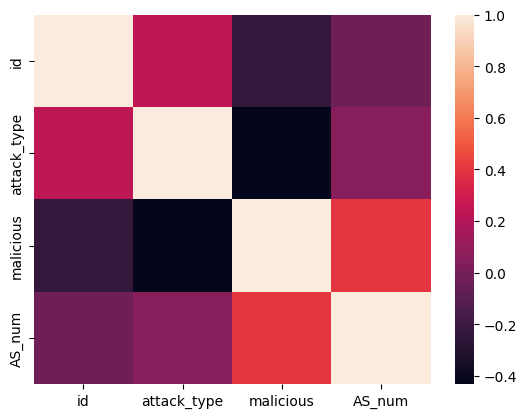

In [ ]:
# heatmap

sns.heatmap(df_malicious_ips[['id','attack_type','malicious','AS_num']].corr())


#### Data Preparation

In [ ]:
df_malicious_ips[['id','malicious','AS_num']]

,id,malicious,AS_num
0,78,1,9299
1,508,1,174
2,617,1,202425
3,980,1,208323
4,1146,1,3269
...,...,...,...
3190,1340791,1,14061
3191,1341647,1,396982
3192,1344817,1,56046
3193,1348053,1,14061


In [ ]:
# Data Preparation

# Convert data to numpy array
X = df_malicious_ips[['id','malicious','AS_num']].to_numpy()
y = np.array(df_malicious_ips['attack_type'])

# Train Test Split 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)




# Feature Scaling
scaler = MinMaxScaler()  

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)





In [ ]:
X_train.shape

(2556, 3)

In [ ]:
X_test.shape

(639, 3)

In [ ]:
y_train.shape

(2556,)

In [ ]:
y_test.shape

(639,)

# Initial Training : Manual Model

In [ ]:
# Training 

classifier = SVC(kernel = 'rbf', random_state = 0)
classifier.fit(X_train, y_train)


# Prediction 
y_pred = classifier.predict(X_test) 
y_pred

array([3, 3, 3, 3, 3, 0, 3, 3, 5, 3, 3, 3, 3, 0, 3, 0, 3, 5, 3, 3, 3, 0,
       5, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 0, 3, 3,
       3, 3, 3, 0, 5, 3, 5, 3, 4, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 5, 0,
       3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 0, 4, 3,
       3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 0, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 0, 3, 0, 3, 5,
       3, 3, 0, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 0, 3, 3,
       3, 3, 3, 0, 4, 3, 0, 3, 0, 5, 0, 3, 3, 3, 3, 3, 3, 3, 0, 5, 3, 3,
       3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 0, 5, 0, 3, 3, 3, 4, 3, 3,
       3, 3, 3, 3, 3, 3, 0, 3, 3, 0, 3, 3, 5, 3, 3, 3, 5, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 0, 0, 3, 5, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3,
       0, 3, 0, 3, 3, 3, 3, 0, 0, 3, 3, 3, 5, 5, 3, 3, 3, 3, 3, 5, 3, 0,
       3, 3, 3, 4, 3, 0, 0, 0, 3, 0, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 5, 5, 3, 4, 3, 5, 3, 5, 3, 3, 5, 3, 3,

In [ ]:
#confusion matrix 
print(' Classes' ,classifier.classes_)
cm = confusion_matrix(y_test, y_pred)

cm

 Classes [0 1 2 3 4 5]


array([[ 38,   0,   0,  52,   0,   0],
       [  4,   0,   0,   6,   0,   0],
       [  0,   0,   0,   8,   0,   0],
       [ 43,   0,   0, 386,   2,  25],
       [  4,   0,   0,  13,  13,   0],
       [  0,   0,   0,   1,   0,  44]], dtype=int64)

In [ ]:

print ("Accuracy : ", accuracy_score(y_test, y_pred))

Accuracy :  0.7527386541471048


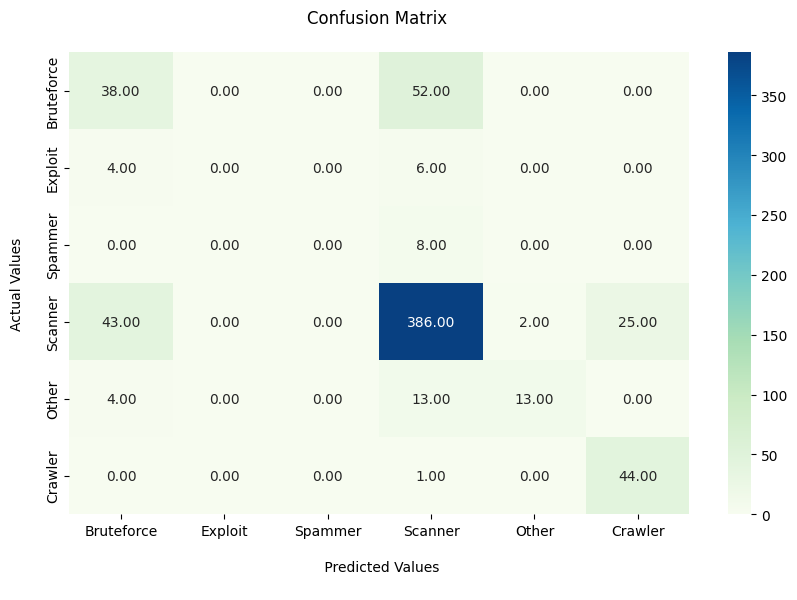

In [ ]:
plt.figure(figsize=(10,6))
fx=sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, fmt=".2f",cmap="GnBu")
fx.set_title('Confusion Matrix \n')
fx.set_xlabel('\n Predicted Values\n')
fx.set_ylabel('Actual Values\n')
fx.xaxis.set_ticklabels(attack_types)
fx.yaxis.set_ticklabels(attack_types)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.43      0.42      0.42        90
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00         8
           3       0.83      0.85      0.84       456
           4       0.87      0.43      0.58        30
           5       0.64      0.98      0.77        45

    accuracy                           0.75       639
   macro avg       0.46      0.45      0.44       639
weighted avg       0.74      0.75      0.74       639



C:\Users\Samia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Samia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Samia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344

# GridSearchCV SVC Model 

In [ ]:
#MOdleing :

# Select Model
# parameter Selection GridSearch Cross Validation
# Define Grid 




# define parameter range
grid = { 
    'C': [0.1, 1, 10, 100, 1000], 
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf'],
}

# define estimator 
svc_cv = GridSearchCV(estimator=SVC(), param_grid=grid, cv= 5)
svc_cv.fit(X_train, y_train)

# print best parameter after tuning
print(svc_cv.best_params_)
  
# print how our model looks after hyper-parameter tuning
print(svc_cv.best_estimator_)


{'C': 100, 'gamma': 1, 'kernel': 'rbf'}
SVC(C=100, gamma=1)


In [ ]:
# gridsearch prediciton
grid_predictions = svc_cv.predict(X_test)
  
# print classification report
print(classification_report(y_test, grid_predictions))

              precision    recall  f1-score   support

           0       0.44      0.59      0.50        90
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00         8
           3       0.86      0.87      0.86       456
           4       0.76      0.43      0.55        30
           5       1.00      0.96      0.98        45

    accuracy                           0.79       639
   macro avg       0.51      0.47      0.48       639
weighted avg       0.78      0.79      0.78       639



C:\Users\Samia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Samia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Samia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344

In [ ]:


# save the model 
SVC_cv = 'svc_cv.sav'
joblib.dump(svc_cv, SVC_cv)
 

['svc_cv.sav']

# Model 2  : Clustering for Semi-Supervised Learning : Classification of attacks to malicious or not 

##### Data Processing for malicious df

In [ ]:
malicious = malicious.reset_index(drop=True)
malicious.malicious.value_counts()
malicious['malicious'].replace('',np.nan,inplace=True)
# attack type 
attack_types = list(malicious['attack_type'].unique())
print("Attack types are :",attack_types)
malicious['attack_type'] = malicious['attack_type'].replace(['Bruteforce','Exploit','Spammer','Scanner','Other','Crawler'],[0,1,2,3,4,5])

malicious['malicious'].replace('',np.nan,inplace=True)




Attack types are : ['Exploit', 'Bruteforce', 'Spammer', 'Scanner', 'Other', 'Crawler']


In [ ]:
# count number of watchers for each ip


malicious['number_of_watchers'] =malicious.watcher_id.str.count(',')+1


In [ ]:
malicious

,id,watcher_id,attack_type,malicious,AS_num,number_of_watchers
0,3,{21},1,NaN,16509.0,1
1,4,{25},1,NaN,16509.0,1
2,78,{20},0,True,9299.0,1
3,92,{28},1,NaN,16509.0,1
4,93,{26},1,NaN,16509.0,1
...,...,...,...,...,...,...
29182,1350838,"{96848, 7286}",4,NaN,14061.0,2
29183,1350840,"{100844, 7286, 84935}",3,NaN,139190.0,3
29184,1350844,"{7286, 47}",4,NaN,20473.0,2
29185,1351030,"{56291, 56324}",2,NaN,14061.0,2


In [ ]:
malicious.dropna(subset='AS_num',inplace=True)    

In [ ]:
# get number of ips for each AS
sth = list()
for element in malicious.AS_num.values :
    sth.append(df_autonomous_systems.loc[df_autonomous_systems['as_num']== int(float(element)),'n_ips_reported'].values)


In [ ]:
lat_list = [item for sublist in sth for item in sublist]

In [ ]:
len(lat_list)

29173

In [ ]:
malicious.shape

(29186, 6)

In [ ]:
pd.Series(lat_list)

0        30914
1        30914
2          769
3        30914
4        30914
         ...  
29168    19829
29169      169
29170     1218
29171    19829
29172     1808
Length: 29173, dtype: int32

In [ ]:
malicious ['n_ips_by_AS'] = pd.Series(lat_list)

In [ ]:
malicious.dropna(subset='n_ips_by_AS',inplace=True)    

In [ ]:
malicious

,id,watcher_id,attack_type,malicious,AS_num,number_of_watchers,n_ips_by_AS
0,3,{21},1,NaN,16509.0,1,30914.0
1,4,{25},1,NaN,16509.0,1,30914.0
2,78,{20},0,True,9299.0,1,769.0
3,92,{28},1,NaN,16509.0,1,30914.0
4,93,{26},1,NaN,16509.0,1,30914.0
...,...,...,...,...,...,...,...
29168,1350389,"{90480, 78303}",0,NaN,9145.0,2,19829.0
29169,1350399,"{94803, 7286}",4,NaN,51167.0,2,169.0
29170,1350485,"{96848, 25139, 94835, 94637}",4,NaN,16276.0,4,1218.0
29171,1350489,"{96848, 90744}",4,NaN,131724.0,2,19829.0


#### Data Prepareation 





In [ ]:
malicious_labled = malicious.dropna(axis=0)

In [ ]:
malicious_labled

,id,watcher_id,attack_type,malicious,AS_num,number_of_watchers,n_ips_by_AS
2,78,{20},0,True,9299.0,1,769.0
9,508,{25},1,True,174.0,1,863.0
10,617,{290},2,True,202425.0,1,155.0
12,980,{77642},3,True,208323.0,1,37.0
13,1146,{53},0,True,3269.0,1,944.0
...,...,...,...,...,...,...,...
28847,1340791,"{58337, 30287, 49460, 66455, 86552, 72794, 518...",0,True,14061.0,9,255.0
28869,1341647,"{76289, 96386, 66818, 60548, 62726, 101006, 66...",4,True,396982.0,40,30914.0
28962,1344817,"{95200, 94208, 93449, 94637, 61901, 47, 94769,...",4,True,56046.0,13,1449.0
29093,1348053,"{90512, 26228, 7286, 66455, 792, 3161, 77114, ...",3,True,14061.0,9,4372.0


C:\Users\Samia\AppData\Local\Temp\ipykernel_4412\4181144833.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(malicious_labled.corr())


<AxesSubplot: >

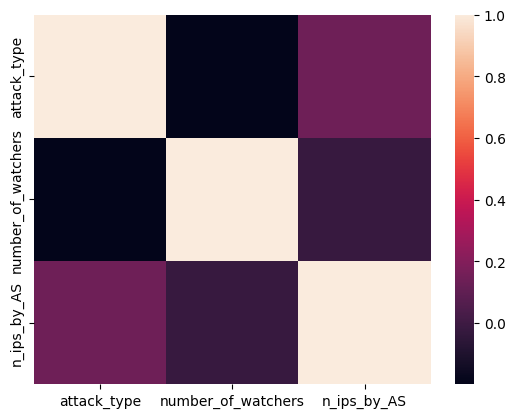

In [ ]:
# Correlation Analsysis 

sns.heatmap(malicious_labled.corr())

In [ ]:
malicious_labled.malicious.value_counts()

False    1125
True     1083
True      939
False      48
Name: malicious, dtype: int64

In [ ]:
# Feature Transorfmation :
# Encoding : 
# malicious column:

malicious_labled['malicious'] = malicious_labled['malicious'].replace("True",'1',regex=True)
malicious_labled['malicious'] = malicious_labled['malicious'].replace("False",'0',regex=True)
#df_malicious_ips['malicious'] = np.where(df_malicious_ips["malicious"]==False,0,1 )
# encode malicious to integer values
malicious_labled['malicious'] = malicious_labled['malicious'].astype(int)

C:\Users\Samia\AppData\Local\Temp\ipykernel_4412\4069775347.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  malicious_labled['malicious'] = malicious_labled['malicious'].replace("True",'1',regex=True)
C:\Users\Samia\AppData\Local\Temp\ipykernel_4412\4069775347.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  malicious_labled['malicious'] = malicious_labled['malicious'].replace("False",'0',regex=True)
C:\Users\Samia\AppData\Local\Temp\ipykernel_4412\4069775347.py:9: SettingWithCopyWarning: 
A value is

In [ ]:
# Data Preparation

# Create a feature space 


df = malicious_labled[['AS_num','attack_type','number_of_watchers','n_ips_by_AS']]


# Convert data to numpy array
X = df.to_numpy()
y = np.array(malicious_labled['malicious'])

# Train Test Split 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)



# Feature Scaling
scaler = StandardScaler()  

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [ ]:
y_train

array([0, 1, 1, ..., 0, 1, 1])

In [ ]:
y_train.shape

(2556,)

In [ ]:
X_train.shape

(2556, 4)

In [ ]:
X_test.shape

(639, 4)

In [ ]:
y_test.shape


(639,)

In [ ]:
# Train a regression Classifier on labeled 
n_labeled = malicious_labled.shape[0]

log_reg = LogisticRegression()
log_reg.fit(X_train[:n_labeled], y_train[:n_labeled])

LogisticRegression()

In [ ]:
# accuracy on labeled data only
log_reg.score(X_test, y_test)

0.918622848200313

In [ ]:


# save the model 
logistic_model= 'logistic_reg.sav'
joblib.dump(log_reg, logistic_model)

['logistic_reg.sav']

##### On Unlabled Data 

In [ ]:
# Convert data to numpy array
X = malicious[['AS_num','attack_type','number_of_watchers','n_ips_by_AS']].to_numpy()
y = np.array(malicious['malicious'])

# Train Test Split 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)



# Feature Scaling
scaler = StandardScaler()  

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [ ]:

k = 2
kmeans = KMeans(n_clusters=k)
X_dist = kmeans.fit_transform(X_train)

representative= np.argmin(X_dist, axis=0)
X_representative = X_train[representative]

C:\Users\Samia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
X_representative

array([[ 0.08807128, -0.14948741,  0.01639641, -0.49829989],
       [-0.30762266,  0.48215983, -0.1477576 ,  1.35499333]])

In [ ]:
# cluster centers 
kmeans.cluster_centers_

array([[ 0.09035047, -0.19225483,  0.03776481, -0.48354523],
       [-0.29960865,  0.6375308 , -0.12523082,  1.60347069]])

In [ ]:
kmeans.labels_[np.argmin(X_dist, axis=0)]

array([0, 1])

In [ ]:
X_representative

array([[ 0.08807128, -0.14948741,  0.01639641, -0.49829989],
       [-0.30762266,  0.48215983, -0.1477576 ,  1.35499333]])

In [ ]:


# save the model 
Kmeans_model= 'svc_cv.sav'
joblib.dump(kmeans, Kmeans_model)

In [ ]:
# Manual Labeling 
print(X_representative)
y_representative = np.array([0, 1,]) 
print('\n',y_representative)



[[ 0.08807128 -0.14948741  0.01639641 -0.49829989]
 [-0.30762266  0.48215983 -0.1477576   1.35499333]]

 [0 1]


In [ ]:
# accuracy after first manual labeling 
log_reg = LogisticRegression()
log_reg.fit(X_representative, y_representative)
y_pred = log_reg.predict(X_test)



#### Prospects

* Refactor code into functions
* Refactor code into lower computational complexity
* Experiment with several classifiers for both supervised and semi supervised techniques